# Reflect Tables into SQLAlchemy ORM

In [1]:
# Import Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text
import os

In [2]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create Inspector for Exploration
inspector = inspect(engine)

# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [3]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [4]:
# Get/Print Column Names and Data types for reference - measurement
print('Measurement:')
for column in inspector.get_columns('measurement'):
    primary_key = ""
    if column['primary_key'] == 1:
        primary_key = "Primary Key"
        print(f"{column['name']} - {column['type']} - {primary_key}")
    else:
        print(f"{column['name']} - {column['type']}")

Measurement:
id - INTEGER - Primary Key
station - TEXT
date - TEXT
prcp - FLOAT
tobs - FLOAT


In [5]:
# Get/Print Column Names and Data types for reference - station
print('Station:')
for column in inspector.get_columns('station'):
    primary_key = ""
    if column['primary_key'] == 1:
        primary_key = "Primary Key"
        print(f"{column['name']} - {column['type']} - {primary_key}")
    else:
        print(f"{column['name']} - {column['type']}")

Station:
id - INTEGER - Primary Key
station - TEXT
name - TEXT
latitude - FLOAT
longitude - FLOAT
elevation - FLOAT


In [6]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date))[0][0]

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
query_date = dt.date(recent_date.year - 1, recent_date.month, recent_date.day)

# Print Results
print(f"The most recent date is: {recent_date}")
print(f"The filter date for the query is: {str(query_date)}")

The most recent date is: 2017-08-23 00:00:00
The filter date for the query is: 2016-08-23


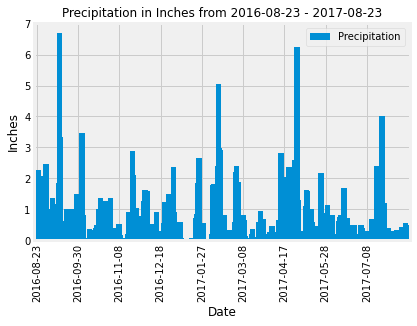

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
query_1 = f"""
SELECT date AS Date, prcp AS Precipitation
  FROM measurement
 WHERE date >= '{str(query_date)}' AND prcp NOT NULL
 GROUP BY station, date
 ORDER BY date
"""

# Read Query into DataFrame
m_df = pd.read_sql(sql=text(query_1), con=engine.connect())

#Set Index to Date Column
m_df.index = m_df['Date']
m_df = m_df['Precipitation'].to_frame()

# Use Pandas Plotting with Matplotlib to plot the data
m_df.plot(kind='bar', y='Precipitation', xlabel='Date', ylabel='Inches', width=30)
plt.title(f'Precipitation in Inches from {str(query_date)} - {dt.datetime.strftime(recent_date, "%Y-%m-%d")}',fontsize=12)
plt.locator_params(axis='x', nbins=9)
plt.savefig(os.path.join('Outputs', 'precipitation.png'), dpi=100, format='png', bbox_inches='tight')
plt.show()

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
m_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [9]:
# Design a query to calculate the total number stations in the dataset
query_2 = session.query(station.station).count()
print(f"There are {query_2} stations in this data set.")

There are 9 stations in this data set.


In [10]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
query_3 = """
            SELECT station AS 'Station ID', COUNT(station) AS Count
              FROM measurement
             GROUP BY station
             ORDER BY Count DESC
          """

# List the stations and the counts in descending order.
counts = pd.read_sql(text(query_3), con=engine.connect())
display(counts)

# Define Most Active station
result_3 = counts.loc[0,'Station ID']
print(f"The Most Active Station is '{result_3}.'")

,Station ID,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


The Most Active Station is 'USC00519281.'


In [11]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query_4 = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs),
                        func.round(func.avg(measurement.tobs),1)).filter(measurement.station == result_3).statement

# Read Query into DataFrame
result_4_df = pd.read_sql(query_4, con=engine.connect())
result_4_df.rename(columns={result_4_df.columns[0]:'Station ID', result_4_df.columns[1]: 'Min Temp',result_4_df.columns[2]:'Max Temp', 
                            result_4_df.columns[3]:'Avg Temp'}, inplace=True)
# Display Statistics
display(result_4_df)

,Station ID,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.7


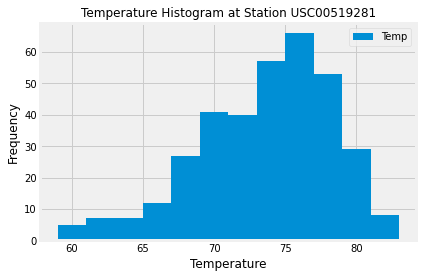

In [12]:
# Using the Most Active Station ID query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_5 = f"""
             SELECT date AS Date, tobs AS Temp
               FROM measurement
              WHERE date >= '{str(query_date)}' and station = '{result_3}'
              ORDER BY date
           """

# Read Query into DataFrame
station_temp_df = pd.read_sql(text(query_5), con=engine.connect())

# Plot Histogram of Temperatures
station_temp_df.plot(kind='hist', bins=12)
plt.title(f'Temperature Histogram at Station {result_3}', fontsize=12)
plt.xlabel('Temperature')
plt.savefig(os.path.join('Outputs', 'temperature_hist.png'), dpi=100, format='png', bbox_inches='tight')
plt.show()

# Close session

In [13]:
# Close Session
session.close()